In [41]:
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from pathlib import Path
import pandas as pd
import xarray as xr
import h5py
from astropy.time import Time
from scipy.interpolate import interp1d
import datetime
import math

In [ ]:
# from overcast import readers as rd
# from overcast.utils import fn2rgt, datainfo, query_rgt, box_sel

In [ ]:
# ROI = 'BEAUFORT'
# dataroot = Path.home()/'shared/data-overcast'/ROI/'subset'

# fns07 = sorted( (dataroot/'ATL07/gt2l').glob('*.nc') )
# track07 = xr.open_mfdataset(fns07)
# fns09 = sorted( (dataroot/'ATL09/profile_2/').glob('*.nc') )
# track09 = xr.open_mfdataset(fns09)

In [2]:
ROI = 'BEAUFORT'
dataroot = Path.home()/'shared/data-overcast'/ROI

# load in data saved by Zheng
track07 = xr.open_dataset(dataroot/'BEA_ATL07_201906.nc')
track09 = xr.open_dataset(dataroot/'BEA_ATL09_201906.nc')

track07.heights[track07.heights > 1000] = float('nan') 
track07.photon_rate[track07.photon_rate > 10000] = float('nan')

In [3]:
# do the interpolation
track07 = track07.swap_dims({'index':'time'})
track09 = track09.swap_dims({'dt':'time'})
new_track09 = track09.interp(time=track07.time.values)


In [ ]:
track07

In [ ]:
new_track09

In [4]:
laytop = new_track09['layer_top'].values
laytop[laytop>20e3] = -100
ctop = laytop.max(axis=1)
laybot = new_track09['layer_bot'].values
cbot = laybot.min(axis=1)

bbox = [-150,75,-110,78]

/srv/conda/envs/notebook/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in greater
  


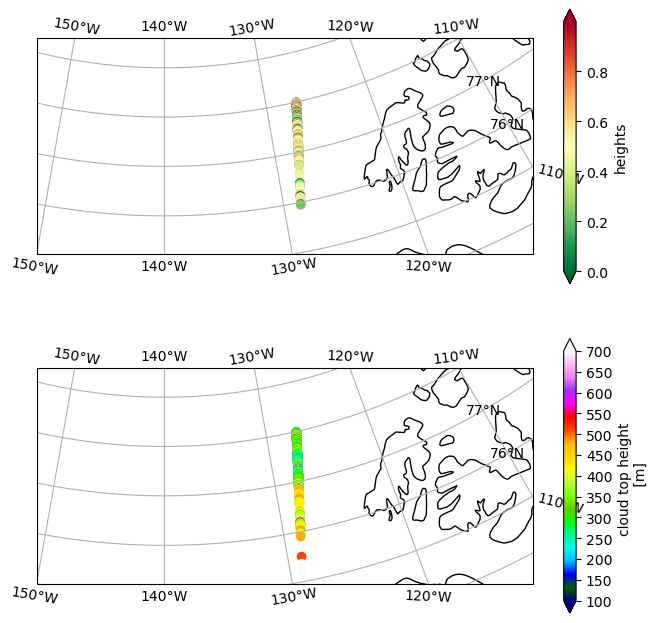

In [20]:
bea_proj = ccrs.NorthPolarStereo(central_longitude=-140)
pcproj   = ccrs.PlateCarree()

fig = plt.figure(1,figsize=(8,8),dpi=100)

vmin = 0; vmax= 1
ticks=np.arange(vmin,vmax,.2)
ax1 = fig.add_subplot(211,projection=bea_proj)
ax1.coastlines(resolution='50m', color='black', linewidth=1)
ax1.set_extent([bbox[0],bbox[2],bbox[1],bbox[3]], pcproj)
ax1.gridlines(draw_labels=True)
# cs = ax1.contour(dsera_cut.lons,dsera_cut.lats,dsera_cut.slp/100,colors='k',transform=pcproj)
# ax1.clabel(cs,cs.levels, inline=True,fontsize=10,fmt='%.1f')
hdl = plt.scatter(track07['lons'][::50],track07['lats'][::50],c=track07.heights[::50], 
            cmap=plt.cm.get_cmap('RdYlGn').reversed(), 
            vmin=vmin,vmax=vmax,
            transform=pcproj)

plt.colorbar(label="heights", shrink=1, ticks=ticks,extend='both');

ax2 = fig.add_subplot(212,projection=bea_proj)
ax2.coastlines(resolution='50m', color='black', linewidth=1)
ax2.set_extent([bbox[0],bbox[2],bbox[1],bbox[3]], ccrs.PlateCarree())
ax2.gridlines(draw_labels=True)
plt.scatter(track07['lons'][::20],track07['lats'][::20],c=ctop[::20], 
            cmap=plt.cm.get_cmap('gist_ncar_r').reversed(), 
            vmin=100,vmax=700,
            transform=pcproj)
plt.colorbar(label='cloud top height \n [m]', shrink=1, ticks=np.arange(100,1000,50),extend='both');

In [23]:
# just a peek at the outliers
#plt.scatter(track07.lats,track07.heights, s = 5)


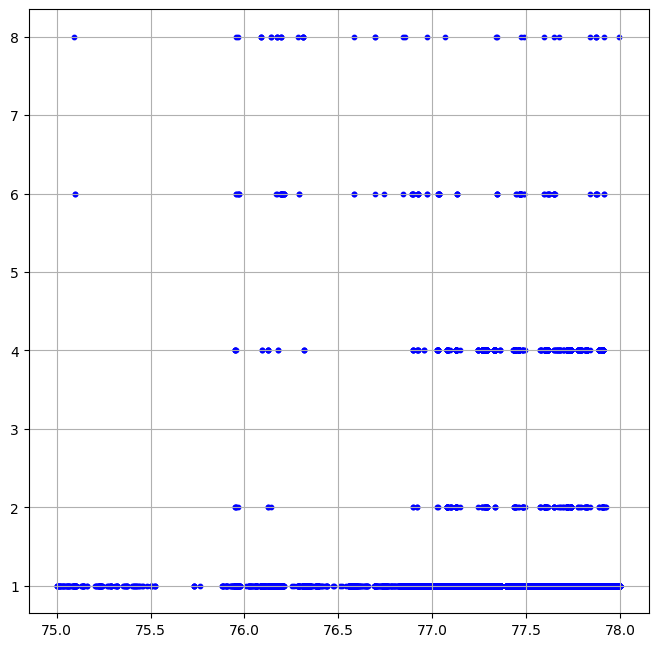

In [31]:
fig = plt.figure(1,figsize=(8,8),dpi=100)
plt.scatter(track07.lats, track07.stype, s =10, c = 'b')
plt.grid()

In [ ]:
# slconditions = (track07.stype > 1) & (track07.stype < 6)
# dlconditions = (track07.stype < 6) 
# iceconditions = (track07.stype < 1.5) 

# # group by surface type
# SpecLeads = track07_interp[slconditions]
# DarkLeads = track07_interp[dlconditions]
# ICEICE    = track07_interp[iceconditions]

# slindex  = SpecLeads.index
# dlindex  = DarkLeads.index
# iceindex = ICEICE.index

# # subset ATL09 by surface type
# # SpecLeads09 = new_track09.isel(dt=slconditions)
# SpecLeads09 = new_track09.where(track07.stype > 1, drop=True)


In [32]:
merged0709= xr.merge([track07.heights, track07.ssh_flag, track07.stype, track07.lats, track07.lons, track07.photon_rate, track07.cloud,new_track09.column_od_asr, new_track09.layer_top, new_track09.layer_bot])
merged0709

<xarray.Dataset>
Dimensions:        (nlay: 10, time: 13463)
Coordinates:
    index          (time) int64 3291 3292 3293 3294 ... 16750 16751 16752 16753
  * time           (time) datetime64[ns] 2019-06-12T01:10:45.690883 ... 2019-06-12T01:11:33.502455
    dt             (time) float64 nan nan nan nan ... 4.554e+07 4.554e+07 nan
  * nlay           (nlay) int32 1 2 3 4 5 6 7 8 9 10
Data variables:
    heights        (time) float32 0.88067824 0.8664065 0.70946014 ... nan nan
    ssh_flag       (time) int8 ...
    stype          (time) int8 1 1 1 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1 1 1 1
    lats           (time) float64 78.0 78.0 78.0 78.0 ... 75.01 75.01 75.0 75.0
    lons           (time) float64 ...
    photon_rate    (time) float32 4.2413793 5.6153846 5.24 ... nan nan nan
    cloud          (time) int16 ...
    column_od_asr  (time) float64 nan nan nan nan ... 3.403e+38 3.403e+38 nan
    layer_top      (time, nlay) float64 nan nan nan nan nan ... nan nan nan nan
    layer_bot      (time, nlay) float64 nan nan nan nan nan ... nan nan nan nan

In [9]:
SpecLeads_OD = merged0709.column_od_asr.where(merged0709.stype > 1)
DarkLeads_OD = merged0709.column_od_asr.where(merged0709.stype > 5)
Ice_OD   = merged0709.column_od_asr.where(merged0709.stype == 1)
Non_OD   = merged0709.column_od_asr.where(merged0709.stype == 0)

In [33]:
#plt.plot(merged0709.lats,SpecLeads_OD.where(SpecLeads_OD < 1000))

Text(0.5, 1.0, 'Normalized histograms of Cloud Optical Depth over Surface Types')

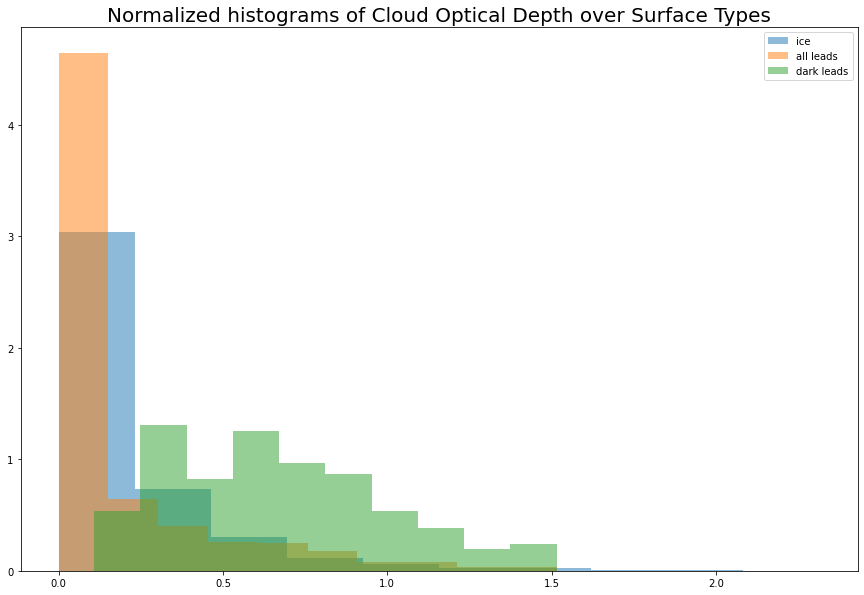

In [50]:
fig = plt.figure(figsize=(15,10))

# ax[0].hist()
# ax[0].hist(SpecLeads_OD.where(SpecLeads_OD < 1000), density=True)

plt.hist(Ice_OD.where(Ice_OD < 1000), density = True, alpha = 0.5, label = 'ice')
plt.hist(SpecLeads_OD.where(SpecLeads_OD < 1000), density = True, alpha = 0.5, label = 'all leads')
plt.hist(DarkLeads_OD.where(DarkLeads_OD < 1000), density = True, alpha = 0.5, label = 'dark leads')
plt.legend()
plt.title('Normalized histograms of Cloud Optical Depth over Surface Types', fontsize = 20)

In [ ]:
# def interpolate_track(product1_dt, product1_variable, product2_dt, int_type='nearest'):
    
    
#     # in the case here, we are always interpolating ATL07 to ATL09
#     change = interp1d(product1_dt, product1_variable, kind = int_type, bounds_error = False)
    
#     dt2_var1 = change(product2_dt)
    
#     return dt2_var1